# Machine learning - Features extraction

Runs binary and multi-class classifiers on a given dataset.
Dataset are read as Parquet file. The dataset must contain a feature vector named "features" and a classification column.

## Imports

In [1]:
import pandas as pd
import mltoolkit
from pyspark.sql import SparkSession
import numpy as np
import sklearn

## Configure Spark Session

In [2]:
spark = SparkSession.builder.appName("datasetClassifier").getOrCreate()

## Read in data from parquet file

In [3]:
parquetFile = './input_features/'
data = spark.read.parquet(parquetFile).cache()

df = data.toPandas()
print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 18491


,structureChainId,alpha,beta,coil,foldType,features
0,1LBU.A,0.361502,0.107981,0.530516,other,"[0.4114873782415294, 0.495768271755638, 0.1086..."
1,1LC0.A,0.410345,0.275862,0.313793,alpha+beta,"[0.33633328095370896, 0.62037980757374, 0.1313..."
2,1LC5.A,0.428169,0.157746,0.414084,alpha+beta,"[0.3894081898880276, 0.3611422935398116, 0.065..."
3,1LFP.A,0.427984,0.234568,0.337449,alpha+beta,"[0.3926710381225172, 0.4961378212319687, 0.186..."
4,1LFW.A,0.322650,0.273504,0.403846,alpha+beta,"[0.47657807861397194, 0.45641881047186056, 0.1..."


## Select only alpha and beta foldType

In [4]:
df = df[(df.foldType == 'alpha') | (df.foldType == 'beta')]

print(f"Total number of data: {df.shape[0]}")
df.head()

Total number of data: 4937


,structureChainId,alpha,beta,coil,foldType,features
5,1LGH.A,0.857143,0.0,0.142857,alpha,"[0.540186581405049, 0.11621746813709086, 0.267..."
6,1LGH.B,0.744186,0.0,0.255814,alpha,"[0.3572499892589721, 0.39487065611915156, 0.41..."
7,1LGH.D,0.857143,0.0,0.142857,alpha,"[0.540186581405049, 0.11621746813709086, 0.267..."
8,1LGH.E,0.744186,0.0,0.255814,alpha,"[0.3572499892589721, 0.39487065611915156, 0.41..."
9,1LGH.G,0.857143,0.0,0.142857,alpha,"[0.540186581405049, 0.11621746813709086, 0.267..."


## Basic dataset information and setting

In [5]:
label = 'foldType'
testFraction = 0.1
seed = 123


vector = df.features.iloc[0]
featureCount = len(vector)
print(f"Feature count    : {featureCount}")

 
classCount = df.foldType.unique().size
print(f"Class count    : {classCount}\n")

  
print(f"Dataset size (unbalanced)    : {df.shape[0]}")
print(df.foldType.value_counts())


df = mltoolkit.downsample(df, 'foldType')
print(f"\nDataset size (balanced)  : {df.shape[0]}")
print(df.foldType.value_counts())

Feature count    : 50
Class count    : 2

Dataset size (unbalanced)    : 4937
alpha    3684
beta     1253
Name: foldType, dtype: int64

Dataset size (balanced)  : 2506
alpha    1253
beta     1253
Name: foldType, dtype: int64


## Random Forest Classifier


 Class	Train	Test

alpha	1110	143

beta	1145	108

Total time taken: 0.18909811973571777

Methods	RandomForestClassifier
AUC	0.9864024864024864
F Score	0.9223744292237445
Accuracy	0.9322709163346613
Precision	0.9099099099099099
Recall	0.9351851851851852
False Positive Rate	0.09009009009009009
True Positive Rate	0.95
	
Confusion Matrix
['alpha' 'beta']
[[133  10]
 [  7 101]]


/anaconda3/envs/mmtf-workshop-2018/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


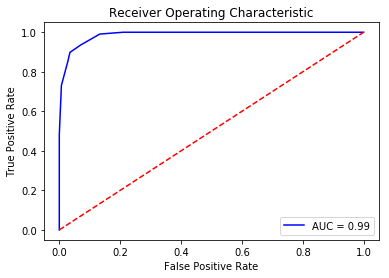

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,12863,1NLQ.E,0.030612,0.622449,0.346939,beta,"[0.48636304322525714, 0.4307996095375758, 0.18...",1,beta
1,10196,1A12.B,0.047382,0.428928,0.523691,beta,"[0.3455793048883562, 0.6248135752659472, 0.145...",1,beta
2,1754,3TZ1.B,0.791667,0.000000,0.208333,alpha,"[0.6778684899858807, 0.656264236115891, 0.4008...",0,alpha
3,6553,5CE7.A,0.792857,0.000000,0.207143,alpha,"[0.5022642215003642, 0.5237047810697084, 0.222...",0,alpha
4,12836,5EQW.D,0.663934,0.040984,0.295082,alpha,"[0.23789842185689836, 0.5894139827301739, 0.32...",0,alpha
5,8016,2VQG.I,0.688312,0.025974,0.285714,alpha,"[0.5090248294231691, 0.5395213214262408, 0.140...",0,alpha
6,359,3SKQ.A,0.647577,0.044053,0.308370,alpha,"[0.45889772787209476, 0.5604396896707194, 0.27...",0,alpha
7,18307,1T3R.A,0.040404,0.535354,0.424242,beta,"[0.7236044691894583, 0.2926359972061247, 0.149...",1,beta
8,13526,3B5O.A,0.760870,0.000000,0.239130,alpha,"[0.35275116378495114, 0.5520807087206792, 0.28...",0,alpha
9,17056,4YY2.B,0.777778,0.000000,0.222222,alpha,"[0.369552604781062, 0.6599444309797357, 0.2405...",0,alpha


In [6]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")

# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)    

print("Sample predictions: ")
mcc.prediction.head(10)

## Logistic Regression Classifier


 Class	Train	Test

alpha	1124	129

beta	1131	122

Total time taken: 0.10200905799865723

Methods	LogisticRegression
AUC	0.9601601219977125
F Score	0.8906250000000001
Accuracy	0.8884462151394422
Precision	0.8507462686567164
Recall	0.9344262295081968
False Positive Rate	0.14925373134328357
True Positive Rate	0.9316239316239316
	
Confusion Matrix
['alpha' 'beta']
[[109  20]
 [  8 114]]


/anaconda3/envs/mmtf-workshop-2018/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


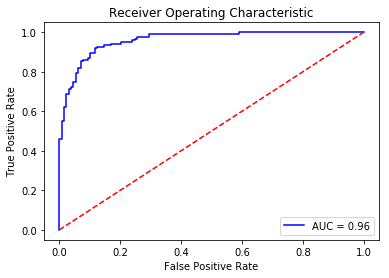

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,11075,5HX0.B,0.024725,0.510989,0.464286,beta,"[0.42549766716024745, 0.45700886462608403, 0.1...",1,beta
1,5932,5IBW.C,0.906977,0.000000,0.093023,alpha,"[0.44515563920140266, 0.5152800281842549, 0.31...",0,alpha
2,1673,3UUL.A,0.869565,0.000000,0.130435,alpha,"[0.35395167065131616, 0.6512013141416078, 0.23...",0,alpha
3,12404,4HDD.A,0.500000,0.000000,0.500000,alpha,"[0.22022418267069718, 0.4800069824529764, 0.17...",0,alpha
4,7986,2VKJ.B,0.783019,0.000000,0.216981,alpha,"[0.4176545830886989, 0.582253695580931, 0.2750...",0,alpha
5,6824,2QDJ.A,0.702703,0.015444,0.281853,alpha,"[0.4676435657441862, 0.47318750985655256, 0.23...",0,alpha
6,16689,2H77.A,0.619608,0.047059,0.333333,alpha,"[0.4252150070248867, 0.4537249341426389, 0.230...",0,alpha
7,15658,1MZ9.C,0.822222,0.000000,0.177778,alpha,"[0.6100460465955125, 0.6194046382707629, 0.155...",0,alpha
8,9139,4RJW.A,0.046948,0.532864,0.420188,beta,"[0.4482334239460597, 0.512276329252451, 0.1534...",1,beta
9,9045,5HON.B,0.038835,0.427184,0.533981,beta,"[0.48083874000272214, 0.3898445715626272, 0.19...",1,beta


In [7]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)
matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Simple Multilayer Perception Classifier


 Class	Train	Test

alpha	1133	120

beta	1122	131

Total time taken: 1.5953989028930664

Methods	MLPClassifier
AUC	0.9374045801526717
F Score	0.8888888888888888
Accuracy	0.8884462151394422
Precision	0.9256198347107438
Recall	0.8549618320610687
False Positive Rate	0.0743801652892562
True Positive Rate	0.8538461538461538
	
Confusion Matrix
['alpha' 'beta']
[[111   9]
 [ 19 112]]


/anaconda3/envs/mmtf-workshop-2018/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


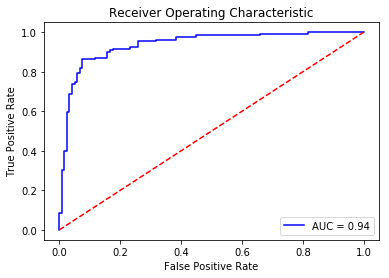

Sample predictions: 


,index,structureChainId,alpha,beta,coil,foldType,features,indexedLabel,predictions
0,5404,2XHA.A,0.031088,0.466321,0.502591,beta,"[0.47282384778372943, 0.43824148310037947, 0.1...",1,beta
1,2820,4KU0.B,0.000000,0.652174,0.347826,beta,"[0.45165941962286044, 0.4208683494282396, 0.01...",1,beta
2,3059,2CWY.A,0.712766,0.021277,0.265957,alpha,"[0.2196331842431939, 0.41722952246025047, -0.0...",0,alpha
3,4213,5SVY.B,0.000000,0.363636,0.636364,beta,"[0.21725919246673586, 0.8029062926769257, 0.57...",1,alpha
4,11317,3OE3.E,0.036585,0.634146,0.329268,beta,"[0.3345050625887114, 0.6172909217012912, 0.313...",1,alpha
5,1009,3QW9.B,0.048193,0.487952,0.463855,beta,"[0.5496647660221372, 0.45139755195805004, 0.37...",1,beta
6,15755,5H1N.B,0.600000,0.000000,0.400000,alpha,"[0.1017686575396012, 0.7048489621853175, 0.202...",0,alpha
7,1152,5FV8.A,0.837838,0.000000,0.162162,alpha,"[0.30005408015504886, 0.7184105476213468, 0.01...",0,alpha
8,1322,4APO.B,0.844156,0.000000,0.155844,alpha,"[0.44361582719834475, 0.49512262386837746, 0.2...",0,alpha
9,2450,4R5R.B,0.000000,0.176471,0.823529,beta,"[0.7106106574855634, 0.22281904318439427, 0.11...",1,beta


In [8]:
from sklearn.neural_network import MLPClassifier

layers = [featureCount, 32, 32, classCount]
clf = MLPClassifier(solver='sgd', \
                    alpha=1e-5, \
                    hidden_layer_sizes = (32, 32))
mcc = mltoolkit.MultiClassClassifier(clf, 'foldType', testFraction=0.1)

matrics = mcc.fit(df)
for k,v in matrics.items(): print(f"{k}\t{v}")
    
# Plot ROC 
mltoolkit.plot_roc(mcc.TPR, mcc.FPR, mcc.AUC)
    
print("Sample predictions: ")
mcc.prediction.head(10)

## Terminate Spark

In [9]:
spark.stop()